# HYDROFOBICITY AND NET CHARGE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from scipy.stats import mannwhitneyu

# === Load Data ===
healthy = pd.read_pickle(f"../pca_vs_umap_vs_autoencoder/healthy_embedding_with_projections.pkl")
healthy = healthy.rename(columns={"healthy_PCA_1": "PCA_1", "healthy_PCA_2": "PCA_2"})

diseased = pd.read_pickle(f"../pca_vs_umap_vs_autoencoder/diseased_embedding_with_projections.pkl")
diseased = diseased.rename(columns={"diseased_PCA_1": "PCA_1", "diseased_PCA_2": "PCA_2"})

df_con = pd.concat([diseased, healthy], ignore_index=True)

# === Define groups ===
df = df_con.copy()
low = df[df['tail'] == 'lower']
middle = df[df['tail'] == 'middle']
high = df[df['tail'] == 'upper']

groups = {
    "Low PPL": low,
    "Central PPL": middle,
    "High PPL": high
}

# === Compute properties ===
def compute_properties(seq_list):
    charge, hydrophobicity = [], []
    for seq in seq_list:
        try:
            analysis = ProteinAnalysis(seq)
            charge.append(analysis.charge_at_pH(7.0))
            hydrophobicity.append(analysis.gravy())
        except:
            continue
    return charge, hydrophobicity

results = {}
for name, group in groups.items():
    charge, hydro = compute_properties(group['sequence'])
    results[name] = {
        'charge': charge,
        'hydro': hydro
    }

# === Boxplots ===
plt.figure(figsize=(14, 6))

# Net Charge
plt.subplot(1, 2, 1)
sns.boxplot(data=[results[g]['charge'] for g in groups], palette="Set2")
plt.xticks(ticks=range(len(groups)), labels=list(groups.keys()))
plt.title("Net Charge @ pH 7")
plt.ylabel("Net Charge")

# Hydrophobicity
plt.subplot(1, 2, 2)
sns.boxplot(data=[results[g]['hydro'] for g in groups], palette="Set2")
plt.xticks(ticks=range(len(groups)), labels=list(groups.keys()))
plt.title("Hydrophobicity (GRAVY)")
plt.ylabel("GRAVY Score")

plt.tight_layout()
plt.savefig("hydrophobicity_charge_by_PPL_group.png")
plt.close()

# === Statistical Tests ===
print("=== Mann–Whitney U Tests ===")
g_names = list(groups.keys())
for i in range(len(g_names)):
    for j in range(i + 1, len(g_names)):
        g1, g2 = g_names[i], g_names[j]
        stat_c, p_c = mannwhitneyu(results[g1]['charge'], results[g2]['charge'])
        stat_h, p_h = mannwhitneyu(results[g1]['hydro'], results[g2]['hydro'])
        print(f"\n{g1} vs {g2}")
        print(f"Net Charge @ pH 7: U = {stat_c:.2e}, p = {p_c:.2e}")
        print(f"Hydrophobicity (GRAVY): U = {stat_h:.2e}, p = {p_h:.2e}")


=== Mann–Whitney U Tests ===

Low PPL vs Central PPL
Net Charge @ pH 7: U = 1.26e+12, p = 0.00e+00
Hydrophobicity (GRAVY): U = 1.69e+12, p = 0.00e+00

Low PPL vs High PPL
Net Charge @ pH 7: U = 4.71e+10, p = 0.00e+00
Hydrophobicity (GRAVY): U = 5.09e+10, p = 0.00e+00

Central PPL vs High PPL
Net Charge @ pH 7: U = 1.16e+12, p = 0.00e+00
Hydrophobicity (GRAVY): U = 8.12e+11, p = 0.00e+00


/tmp/ipykernel_4045945/3418754317.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("inferno_r")
/tmp/ipykernel_4045945/3418754317.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(label_list)
/tmp/ipykernel_4045945/3418754317.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(label_list)


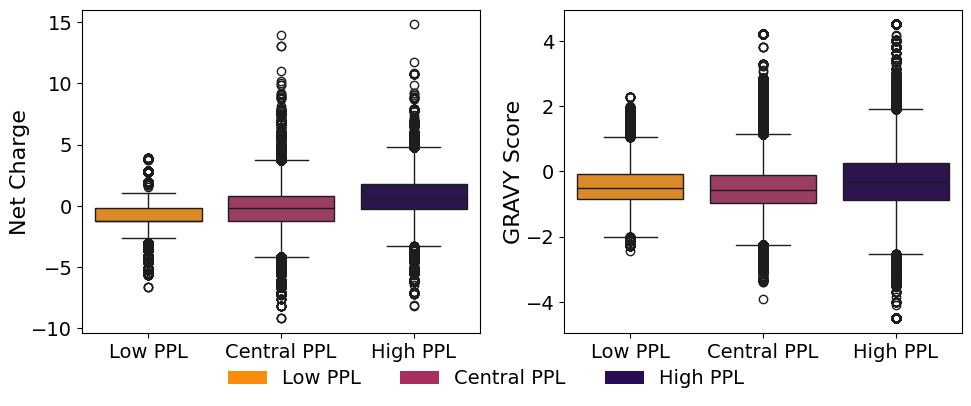

In [2]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from matplotlib.patches import Patch

# === Custom colors and labels ===
cmap = get_cmap("inferno_r")
colors = {
    "lower":  cmap(0.25),  # High PPL – light
    "middle": cmap(0.55),  # Central  – mid
    "upper":  cmap(0.85),  # Low PPL  – dark
}
labels = {
    "lower": "Low PPL",
    "middle": "Central PPL",
    "upper": "High PPL"
}
tails = ["lower", "middle", "upper"]

# === Prepare data ===
charge_data = [results[labels[t]]['charge'] for t in tails]
hydro_data = [results[labels[t]]['hydro'] for t in tails]
color_list = [colors[t] for t in tails]
label_list = [labels[t] for t in tails]

# === Plot settings ===
plt.rcParams.update({
    "font.size":       16,
    "axes.titlesize":  18,
    "axes.labelsize":  16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Net Charge Plot
sns.boxplot(data=charge_data, ax=axes[0], palette=color_list)
axes[0].set_xticklabels(label_list)
axes[0].set_ylabel("Net Charge", labelpad=1)
axes[0].grid(False)

# Hydrophobicity Plot
sns.boxplot(data=hydro_data, ax=axes[1], palette=color_list)
axes[1].set_xticklabels(label_list)
axes[1].set_ylabel("GRAVY Score", labelpad=1)
axes[1].grid(False)

# === Legend: create handles manually ===
legend_handles = [Patch(facecolor=colors[t], label=labels[t]) for t in tails]
fig.legend(handles=legend_handles,
           loc="lower center",
           ncol=3,
           frameon=False,
           bbox_to_anchor=(0.5, -0.05))  # position under the plot

plt.subplots_adjust(wspace=0.25, bottom=0.25)
plt.tight_layout()

plt.savefig("./PAPER_IMG/SI_hydrophobicity_charge_by_PPL_group.svg", dpi=300, bbox_inches='tight')
plt.savefig("./PAPER_IMG/SI_hydrophobicity_charge_by_PPL_group.png", dpi=300, bbox_inches='tight')
plt.show()


# OTHER ANALYSIS:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from scipy.stats import chi2_contingency, mannwhitneyu

# === Load Data ===
healthy = pd.read_pickle(f"../pca_vs_umap_vs_autoencoder/healthy_embedding_with_projections.pkl")
healthy = healthy.rename(columns={"healthy_PCA_1": "PCA_1", "healthy_PCA_2": "PCA_2"})

diseased = pd.read_pickle(f"../pca_vs_umap_vs_autoencoder/diseased_embedding_with_projections.pkl")
diseased = diseased.rename(columns={"diseased_PCA_1": "PCA_1", "diseased_PCA_2": "PCA_2"})

df_con = pd.concat([diseased, healthy], ignore_index=True)

# === Define groups ===
df = df_con.copy()
middle = df[df['tail'] == 'middle']
upper = df[df['tail'] == 'upper']
lower = df[df['tail'] == 'lower']
tails = pd.concat([upper, lower])

In [4]:
df.columns

Index(['id', 'sequence', 'label', 'v_identity', 'd_identity', 'j_identity',
       'v_family', 'd_family', 'j_family', 'c_family', 'perplexity',
       'frequency', 'patient_id', 'group', 'tail', 'embeddings', 'PCA_1',
       'PCA_2', 'diseased_UMAP_1', 'diseased_UMAP_2', 'diseased_AE_1',
       'diseased_AE_2', 'healthy_UMAP_1', 'healthy_UMAP_2', 'healthy_AE_1',
       'healthy_AE_2'],
      dtype='object')

# PERPLEXITY DISTRIBUTION

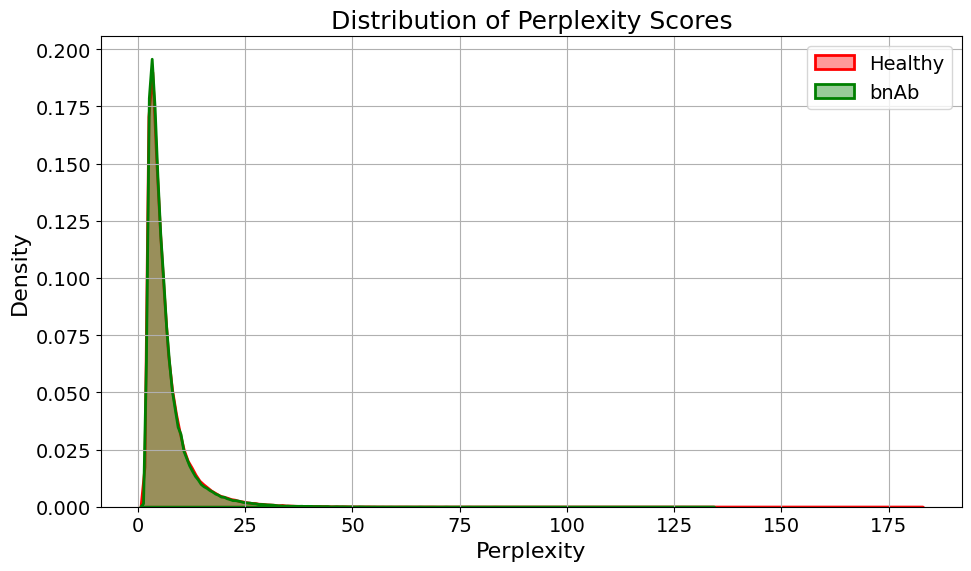

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supponiamo che i tuoi DataFrame si chiamino healthy_df e bnab_df

plt.figure(figsize=(10, 6))

# KDE plot per una visione liscia
sns.kdeplot(healthy['perplexity'], label='Healthy', fill=True, alpha=0.4, linewidth=2, color='red')
sns.kdeplot(diseased['perplexity'], label='bnAb', fill=True, alpha=0.4, linewidth=2, color='green')

plt.title('Distribution of Perplexity Scores')
plt.xlabel('Perplexity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


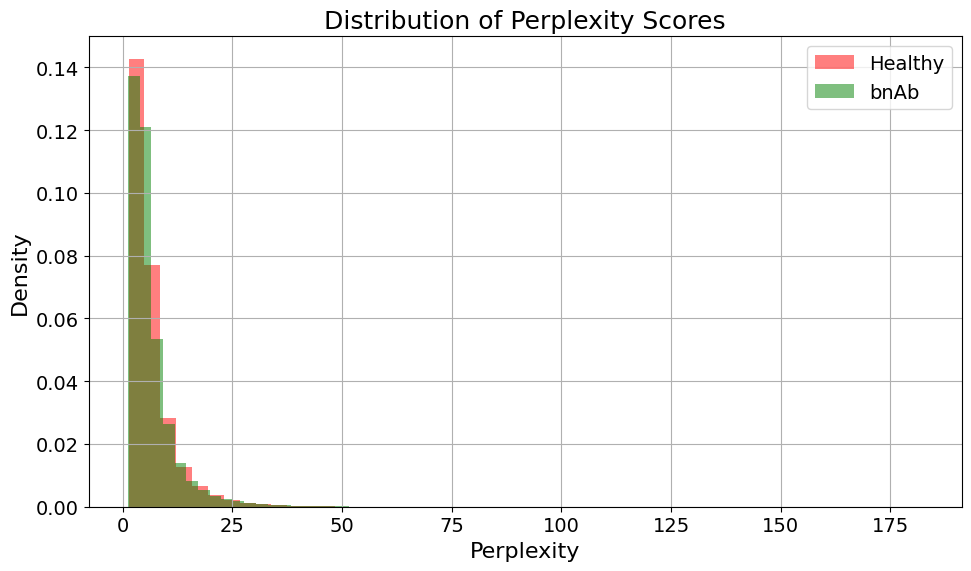

In [6]:
plt.figure(figsize=(10, 6))

plt.hist(healthy['perplexity'], bins=50, alpha=0.5, label='Healthy', color='red', density=True)
plt.hist(diseased['perplexity'], bins=50, alpha=0.5, label='bnAb', color='green', density=True)

plt.title('Distribution of Perplexity Scores')
plt.xlabel('Perplexity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


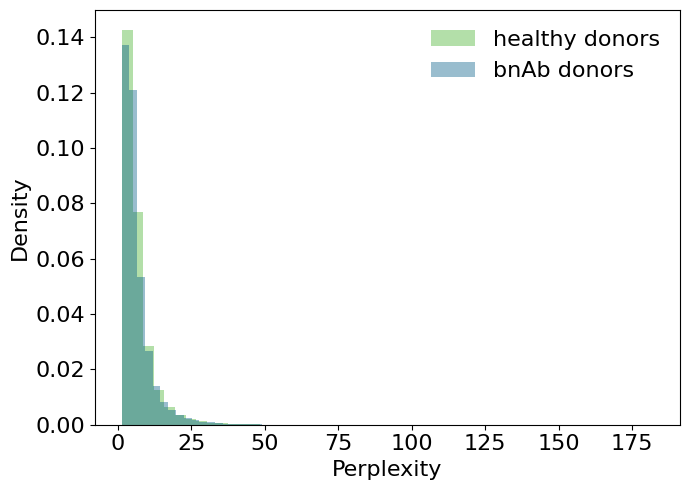

In [7]:
import matplotlib.pyplot as plt

# Impostazioni generali di stile
plt.style.use('default')  # oppure 'seaborn-whitegrid'
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 16,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# Crea figura e singolo asse
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

# --- HISTOGRAMMA SOVRAPPOSTO ---
bins = 50
ax.hist(healthy['perplexity'], bins=bins, alpha=0.4, label='healthy donors', color='#43B02A', density=True)
ax.hist(diseased['perplexity'], bins=bins, alpha=0.4, label='bnAb donors', color='#005A86', density=True)

# Etichette e stile
#ax.set_title('Perplexity Distribution')
ax.set_xlabel('Perplexity')
ax.set_ylabel('Density')
ax.legend(frameon=False)
ax.grid(False)

# Layout ordinato
plt.tight_layout()
plt.show()



/tmp/ipykernel_4045945/963958455.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


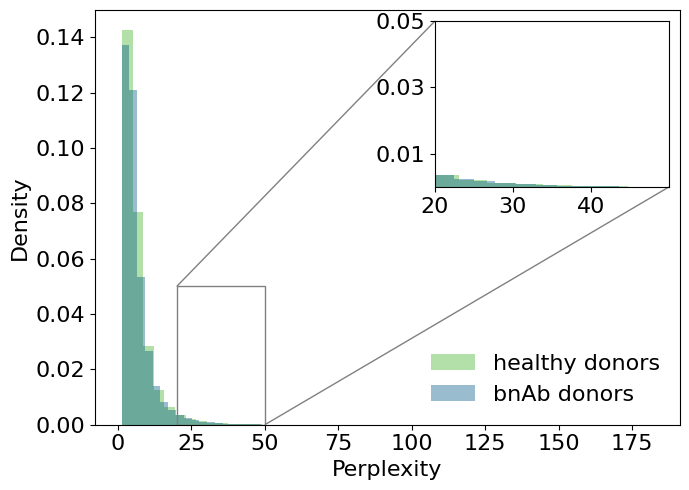

✓ Plot salvato come:
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/SI_perplexity_distributions.svg
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/SI_perplexity_distributions.png


In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Impostazioni generali di stile
plt.style.use('default')
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 16,
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# Crea figura e asse principale
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

# Histogramma sul grafico principale
bins = 50
ax.hist(healthy['perplexity'], bins=bins, alpha=0.4, label='healthy donors', color='#43B02A', density=True)
ax.hist(diseased['perplexity'], bins=bins, alpha=0.4, label='bnAb donors', color='#005A86', density=True)

# Etichette
ax.set_xlabel('Perplexity')
ax.set_ylabel('Density')
ax.legend(frameon=False, loc='lower right')
ax.grid(False)

# --- INSET: ZOOM tra 25 e 50 ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Inset: zoom tra PPL 25–50 e Y max 0.05
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
axins.hist(healthy['perplexity'], bins=bins, alpha=0.4, color='#43B02A', density=True)
axins.hist(diseased['perplexity'], bins=bins, alpha=0.4, color='#005A86', density=True)

# Imposta limiti
axins.set_xlim(20, 50)
axins.set_ylim(0, 0.05)

# Ticks personalizzati (opzionale)
axins.set_xticks([20, 30, 40])
axins.set_yticks([0.01, 0.03, 0.05])

# Riquadro e collegamenti
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Finalizza
plt.tight_layout()
plt.show()
out_svg = "./PAPER_IMG/SI_perplexity_distributions.svg"
out_png = "./PAPER_IMG/SI_perplexity_distributions.png"

fig.savefig(out_svg, format="svg",  bbox_inches="tight", pad_inches=0.01)
fig.savefig(out_png, format="png",  dpi=600, bbox_inches="tight",
            pad_inches=0.01, pil_kwargs={"compress_level": 0})
import os
print(f"✓ Plot salvato come:\n  • {os.path.abspath(out_svg)}\n  • {os.path.abspath(out_png)}")

# AA ENRICHMENT

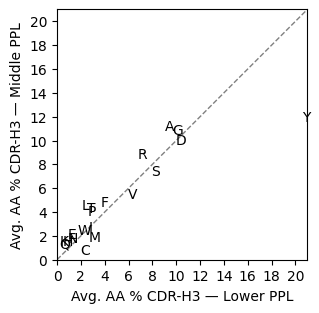

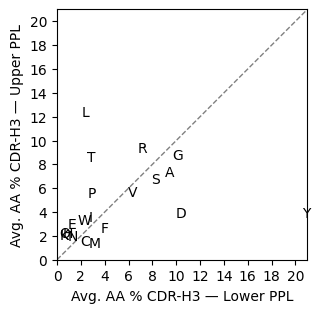

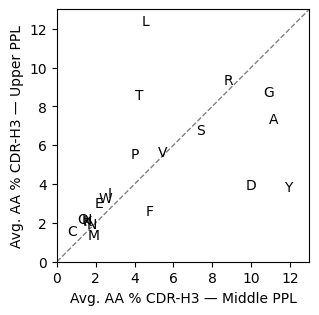

In [9]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from itertools import combinations
from collections import Counter

# ── 1. Prepare one mean-frequency vector per tail ─────────────────────
AA = list("ACDEFGHIKLMNPQRSTVWY")

def mean_freq(seq_series):
    rows = []
    for seq in seq_series:
        L, c = len(seq), Counter(seq)
        rows.append({aa: c.get(aa, 0) / L * 100 for aa in AA})
    return pd.DataFrame(rows).fillna(0).mean()

df = df_con.copy()
tails = ["lower", "middle", "upper"]

mean_dict = {
    t: mean_freq(df.loc[df["tail"] == t, "sequence"]).rename(t)
    for t in tails
}

# ── 2. Styling (unchanged) ────────────────────────────────────────────
plt.rcParams.update({
    "font.size":       10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlesize":  11,
    "axes.labelsize":  10,
})

# ── 3. Generate one plot for every pair of tails ──────────────────────
for x_tail, y_tail in combinations(tails, 2):          # (lower,middle)… etc.
    plot_df = (
        pd.concat([mean_dict[x_tail], mean_dict[y_tail]], axis=1)
          .reset_index()
          .rename(columns={"index": "AA"})
    )

    # shared axis limits
    raw_max = plot_df[[x_tail, y_tail]].max().max()
    maxval  = math.ceil(raw_max)
    minval  = 0

    locator = MultipleLocator(2)

    # --- scatter plot --------------------------------------------------
    fig, ax = plt.subplots(figsize=(3, 3))

    for _, r in plot_df.iterrows():
        ax.text(r[x_tail], r[y_tail], r["AA"],
                ha="center", va="center", fontsize=10)

    ax.plot([minval, maxval], [minval, maxval],
            ls="--", lw=1, color="grey")

    ax.set_xlim(minval, maxval)
    ax.set_ylim(minval, maxval)
    ax.set_aspect("equal", adjustable="box")
    ax.xaxis.set_major_locator(locator)
    ax.yaxis.set_major_locator(locator)

    ax.set_xlabel(f"Avg. AA % CDR-H3 — {x_tail.capitalize()} PPL")
    ax.set_ylabel(f"Avg. AA % CDR-H3 — {y_tail.capitalize()} PPL")

    fig.tight_layout(pad=0.05)
    plt.show()


/tmp/ipykernel_4045945/1200264597.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("inferno_r")


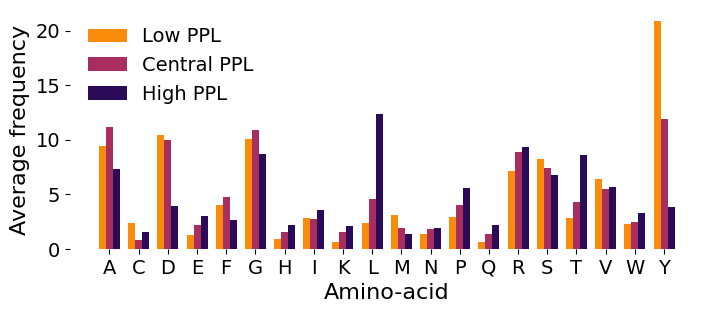

✓ Plot salvato come:
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/PAPER_aa_freq_tails.svg
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/PAPER_aa_freq_tails.png


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from collections import Counter
import os

# ── Split nelle tre tails ────────────────────────────────────────────
df       = df_con.copy()
lower    = df[df["tail"] == "lower"]
middle   = df[df["tail"] == "middle"]
upper    = df[df["tail"] == "upper"]

# ── Media % per amminoacido ──────────────────────────────────────────
AA = list("ACDEFGHIKLMNPQRSTVWY")
def mean_freq(series):
    rows = []
    for seq in series:
        L = len(seq)
        c = Counter(seq)
        rows.append({aa: c.get(aa, 0) / L * 100 for aa in AA})
    return pd.DataFrame(rows).fillna(0).mean()

plot_df = (
    pd.concat([mean_freq(lower["sequence"]).rename("Lower"),
               mean_freq(middle["sequence"]).rename("Middle"),
               mean_freq(upper["sequence"]).rename("Upper")], axis=1)
      .reset_index().rename(columns={"index": "AA"})
)

# ── Stile compatto + font grandi ─────────────────────────────────────
plt.rcParams.update({
    "font.size":       16,
    "axes.titlesize":  18,
    "axes.labelsize":  16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

# --- Palette: inferno_r, valori più alti = più scuri -----------------
cmap   = get_cmap("inferno_r")
colors = [cmap(0.85),   # Lower  -> molto scuro
          cmap(0.55),   # Middle -> tono intermedio
          cmap(0.25)]   # Upper  -> più chiaro

# ── Bar-plot compatto ────────────────────────────────────────────────
x, w   = np.arange(len(AA)), 0.24
fig, ax = plt.subplots(figsize=(7, 3))    # canvas stretto

ax.bar(x - w, plot_df["Lower"],  width=w, color=colors[2], label="Low PPL")
ax.bar(x     , plot_df["Middle"], width=w, color=colors[1], label="Central PPL")
ax.bar(x + w, plot_df["Upper"],  width=w, color=colors[0], label="High PPL")


ax.set_xticks(x)
ax.set_xticklabels(AA)
ax.set_ylabel("Average frequency")
ax.set_xlabel("Amino-acid")
ax.legend(frameon=False, ncol=1, loc="upper left")

# Rimuovo la cornice
for spine in ax.spines.values():
    spine.set_visible(False)

fig.tight_layout(pad=0.15)
plt.show()
# ----------------------------------------------------------------------
# 6) -- salvataggio high-quality ---------------------------------------
# ----------------------------------------------------------------------
out_svg = "./PAPER_IMG/PAPER_aa_freq_tails.svg"
out_png = "./PAPER_IMG/PAPER_aa_freq_tails.png"

fig.savefig(out_svg, format="svg",  bbox_inches="tight", pad_inches=0.01)
fig.savefig(out_png, format="png",  dpi=600, bbox_inches="tight",
            pad_inches=0.01, pil_kwargs={"compress_level": 0})

print(f"✓ Plot salvato come:\n  • {os.path.abspath(out_svg)}\n  • {os.path.abspath(out_png)}")


In [11]:
import pandas as pd

# ---- quick sanity-check ------------------------------------------------
# Raggruppa per 'tail' e calcola le statistiche descrittive di perplexity
stats = (
    df_con                       # <-- il tuo DataFrame originale
      .groupby('tail')['perplexity']
      .agg(['min', 'median', 'mean', 'max'])
      .sort_values('median')     # ordina dalla coda più "bassa"
)

print(stats)


              min     median       mean         max
tail                                               
lower    1.244328   2.037253   2.005180    2.237277
middle   2.221193   4.805316   5.744249   16.618200
upper   16.413448  21.319031  23.707564  182.254379


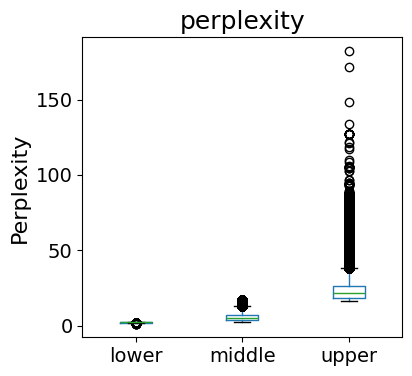

In [12]:
import matplotlib.pyplot as plt

df_con.boxplot(column='perplexity', by='tail', grid=False,
               showfliers=True, figsize=(4,4))
plt.suptitle("")                # rimuove il titolo superfluo
plt.xlabel("")                  # opzionale: etichetta più pulita
plt.ylabel("Perplexity")
plt.show()


## length distribution

/tmp/ipykernel_4045945/1186694157.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("inferno_r")


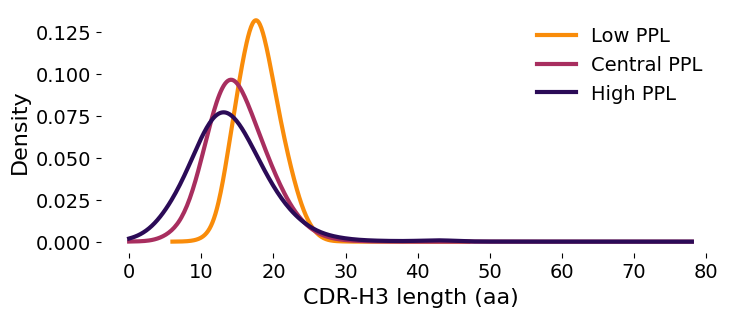

✓ Plot salvato come:
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/SI_PAPER_aa_len_tails.svg
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/SI_aa_len_tails.png


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.stats import gaussian_kde
import os

# ── dati e lunghezze ────────────────────────────────────────────────
df_len = df_con.copy()
df_len["seq_len"] = df_len["sequence"].str.len()

# ── stile coerente con gli altri plot ───────────────────────────────
plt.rcParams.update({
    "font.size":       16,
    "axes.titlesize":  18,
    "axes.labelsize":  16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

cmap   = get_cmap("inferno_r")
colors = {"upper":  cmap(0.85),
          "middle": cmap(0.55),
          "lower":  cmap(0.25)}
labels = {"lower": "Low PPL", "middle": "Central PPL", "upper": "High PPL"}

fig, ax = plt.subplots(figsize=(7, 3))   # canvas compatto

for tail in ["lower", "middle", "upper"]:
    data = df_len.loc[df_len["tail"] == tail, "seq_len"].values
    if len(data) < 2:
        continue
    kde = gaussian_kde(data, bw_method=0.4)    # <-- bandwidth più ampio
    xs  = np.linspace(data.min() - 1, data.max() + 1, 400)
    ax.plot(xs, kde(xs), color=colors[tail], lw=3, label=labels[tail])

ax.set_xlabel("CDR-H3 length (aa)")
ax.set_ylabel("Density")
ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ── Rimuovo l’intero frame (tutte le spines) ─────────────────────────
for spine in ax.spines.values():
    spine.set_visible(False)
    
fig.tight_layout(pad=0.05)
plt.show()

# ----------------------------------------------------------------------
# 6) -- salvataggio high-quality ---------------------------------------
# ----------------------------------------------------------------------
out_svg = "PAPER_IMG/SI_PAPER_aa_len_tails.svg"
out_png = "PAPER_IMG/SI_aa_len_tails.png"

fig.savefig(out_svg, format="svg",  bbox_inches="tight", pad_inches=0.01)
fig.savefig(out_png, format="png",  dpi=600, bbox_inches="tight",
            pad_inches=0.01, pil_kwargs={"compress_level": 0})

print(f"✓ Plot salvato come:\n  • {os.path.abspath(out_svg)}\n  • {os.path.abspath(out_png)}")



/tmp/ipykernel_4045945/2100202464.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("inferno_r")


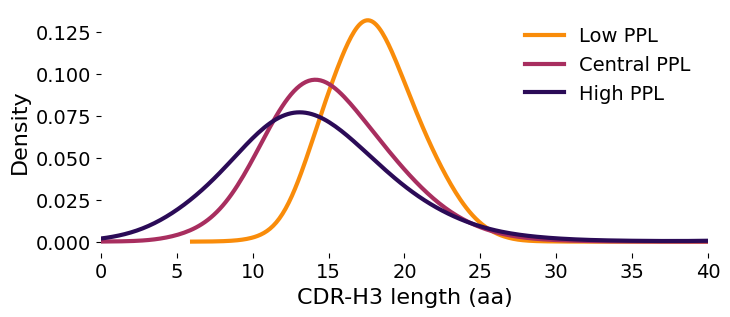

✓ Plot salvato come:
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/SI_PAPER_aa_len_tails.svg
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/tails_differences/PAPER_IMG/SI_aa_len_tails.png


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.stats import gaussian_kde
import os

# ── dati e lunghezze ────────────────────────────────────────────────
df_len = df_con.copy()
df_len["seq_len"] = df_len["sequence"].str.len()

# ── stile coerente con gli altri plot ───────────────────────────────
plt.rcParams.update({
    "font.size":       16,
    "axes.titlesize":  18,
    "axes.labelsize":  16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

cmap   = get_cmap("inferno_r")
colors = {"upper":  cmap(0.85),
          "middle": cmap(0.55),
          "lower":  cmap(0.25)}
labels = {"lower": "Low PPL", "middle": "Central PPL", "upper": "High PPL"}

fig, ax = plt.subplots(figsize=(7, 3))   # canvas compatto

for tail in ["lower", "middle", "upper"]:
    data = df_len.loc[df_len["tail"] == tail, "seq_len"].values
    if len(data) < 2:
        continue
    kde = gaussian_kde(data, bw_method=0.4)    # <-- bandwidth più ampio
    xs  = np.linspace(data.min() - 1, data.max() + 1, 400)
    ax.plot(xs, kde(xs), color=colors[tail], lw=3, label=labels[tail])

ax.set_xlabel("CDR-H3 length (aa)")
ax.set_ylabel("Density")
ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ── Rimuovo l’intero frame (tutte le spines) ─────────────────────────
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlim(0, 40)

fig.tight_layout(pad=0.05)
plt.show()

# ----------------------------------------------------------------------
# 6) -- salvataggio high-quality ---------------------------------------
# ----------------------------------------------------------------------
out_svg = "PAPER_IMG/SI_PAPER_aa_len_tails.svg"
out_png = "PAPER_IMG/SI_aa_len_tails.png"

fig.savefig(out_svg, format="svg",  bbox_inches="tight", pad_inches=0.01)
fig.savefig(out_png, format="png",  dpi=600, bbox_inches="tight",
            pad_inches=0.01, pil_kwargs={"compress_level": 0})

print(f"✓ Plot salvato come:\n  • {os.path.abspath(out_svg)}\n  • {os.path.abspath(out_png)}")



Total sequences: 8,649,880
Sequences >50 aa: 3,183 (0.036798%)
Maximum length: 77

Examples of ultra-long sequences (>40 aa):


,id,sequence,label,v_identity,d_identity,j_identity,v_family,d_family,j_family,c_family,...,PCA_2,diseased_UMAP_1,diseased_UMAP_2,diseased_AE_1,diseased_AE_2,healthy_UMAP_1,healthy_UMAP_2,healthy_AE_1,healthy_AE_2,seq_len
2644,SRR7718228.6700,ASLLAVTMGR*LIINYYYYMDVWGKGTTVTVSLGFYGTGSYYKLLL...,BRO,96.386,95.833,100.000,IGHV5-10-1,IGHD3-10,IGHJ6,NaN,...,-10.274194,-0.657887,0.903176,25.745705,137.672195,NaN,NaN,NaN,NaN,50
15487,SRR7718228.793,SRRGSANLG*FSEVTAFRRSRGEGVEGIGDSNQGRDTNYDPSLTRR...,BRO,84.681,100.000,100.000,IGHV4-34,IGHD5-24,IGHJ1,NaN,...,-9.076250,-0.607651,1.401911,20.473444,138.084961,NaN,NaN,NaN,NaN,50
27955,SRR7718228.28084,FTISRDDRVEESRGKVQIHNLKR*CRNHHLSANEQPESRGV*GERG...,BRO,87.660,100.000,100.000,IGHV3-71,IGHD3-22,IGHJ6,NaN,...,-9.860401,-0.622384,1.394003,23.366919,146.631226,NaN,NaN,NaN,NaN,57
28846,SRR7718369.3358,ARDYHLRHI*HQVILD*VGRDSHMRHI**QLVLD*VGPTSLTT,BRO,94.118,88.889,97.917,IGHV3-30,IGHD6-13,IGHJ4,NaN,...,-12.148202,21.729366,-8.561131,43.125008,176.046310,NaN,NaN,NaN,NaN,43
39843,SRR7718369.12429,ARDYHLRHI*HQVILD*VGRDSHMRHI**QLVLD*VGPTSLTT,BRO,94.510,88.889,97.917,IGHV3-30-3,IGHD6-13,IGHJ4,NaN,...,-12.148202,21.726410,-8.564041,43.125008,176.046310,NaN,NaN,NaN,NaN,43


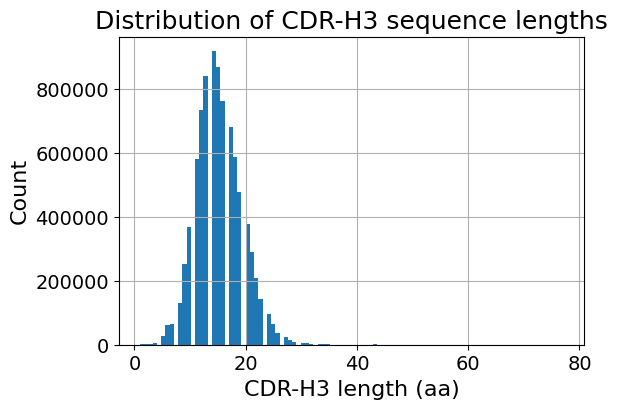

In [15]:
###doublecheck for the paper
import matplotlib.pyplot as plt

# Copy dataframe and add a column with sequence lengths
df_len = df_con.copy()
df_len["seq_len"] = df_len["sequence"].str.len()

# Main statistics
total = len(df_len)
ultra_long_count = (df_len["seq_len"] > 40).sum()
max_len = df_len["seq_len"].max()
ultra_long_pct = ultra_long_count / total * 100

print(f"Total sequences: {total:,}")
print(f"Sequences >50 aa: {ultra_long_count:,} ({ultra_long_pct:.6f}%)")
print(f"Maximum length: {max_len}")

# Show a few ultra-long sequences
print("\nExamples of ultra-long sequences (>40 aa):")
display(df_len[df_len["seq_len"] > 40].head())

# Plot the length distribution
plt.figure(figsize=(6,4))
df_len["seq_len"].hist(bins=100)
plt.xlabel("CDR-H3 length (aa)")
plt.ylabel("Count")
plt.title("Distribution of CDR-H3 sequence lengths")
plt.show()


In [16]:
df_len

,id,sequence,label,v_identity,d_identity,j_identity,v_family,d_family,j_family,c_family,...,PCA_2,diseased_UMAP_1,diseased_UMAP_2,diseased_AE_1,diseased_AE_2,healthy_UMAP_1,healthy_UMAP_2,healthy_AE_1,healthy_AE_2,seq_len
0,SRR7718228.1,ARDSLRYFDYLRDYYYYMDI,BRO,87.698,100.000,94.737,IGHV1-18,IGHD3-9,IGHJ6,NaN,...,1.607299,9.028765,1.101128,5.873321,-124.297600,NaN,NaN,NaN,NaN,20
1,SRR7718228.2,ARGHYDSSG,BRO,95.349,100.000,97.059,IGHV4-39,IGHD3-22,IGHJ4,NaN,...,8.528172,-3.950745,4.473579,216.418655,127.461830,NaN,NaN,NaN,NaN,9
2,SRR7718228.3,ARHLGTGFWSGYYQPDAFDI,BRO,92.829,100.000,93.878,IGHV4-4,IGHD3-3,IGHJ3,NaN,...,-1.129857,1.507042,3.623829,168.791824,-26.031603,NaN,NaN,NaN,NaN,20
3,SRR7718228.4,ATSDFPSAFDI,BRO,98.800,100.000,97.826,IGHV1-24,IGHD3-3,IGHJ3,NaN,...,2.353953,4.616550,-15.969624,777.757080,-124.157059,NaN,NaN,NaN,NaN,11
4,SRR7718228.6,ARGGYGTQVWLLNY,BRO,92.549,83.333,97.436,IGHV3-7,IGHD5-18,IGHJ4,NaN,...,-7.874501,25.495628,11.518967,0.429374,60.518635,NaN,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649875,SRR7718018.42470,ARNSLSGTHPQTLTRRVPYYYGMDV,NON,99.600,100.000,100.000,IGHV1-69,IGHD3-10,IGHJ6,NaN,...,-5.679354,NaN,NaN,NaN,NaN,1.751492,1.840384,-113.892059,-232.753174,25
8649876,SRR7718018.42471,ASPRGGWELPSGGYYYYGMDV,NON,100.000,100.000,100.000,IGHV1-18,IGHD1-26,IGHJ6,NaN,...,-3.478491,NaN,NaN,NaN,NaN,30.541191,-3.541118,-126.377441,-452.051971,21
8649877,SRR7718018.42472,ARGGYSYGVDY,NON,97.222,100.000,100.000,IGHV3-11,IGHD5-18,IGHJ4,NaN,...,22.199545,NaN,NaN,NaN,NaN,-5.825750,-18.755302,3840.944336,-1030.063110,11
8649878,SRR7718018.42473,AKMSR**LR*LRGTPTILLLRYGR,NON,97.233,100.000,100.000,IGHV3-30,IGHD4-17,IGHJ6,NaN,...,-15.353067,NaN,NaN,NaN,NaN,1.177666,0.689261,1844.909912,2018.909790,24


Total sequences: 8,649,880
Sequences >50 aa: 322 (0.003723%)
Maximum length: 77

Tail category counts (overall):
tail
middle    7784920
upper      432489
lower      432471
Name: count, dtype: int64

Tail category counts among ultra-long sequences (>50 aa):
tail
upper     179
middle    143
Name: count, dtype: int64


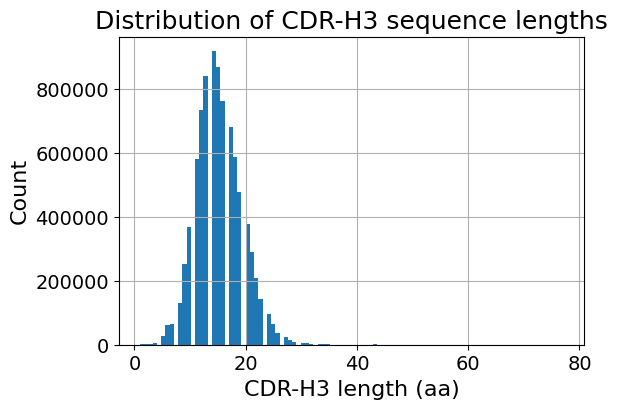

In [17]:
import matplotlib.pyplot as plt

# Copy dataframe and add a column with sequence lengths
df_len = df_con.copy()
df_len["seq_len"] = df_len["sequence"].str.len()

# Main statistics
total = len(df_len)
ultra_long_count = (df_len["seq_len"] > 50).sum()
max_len = df_len["seq_len"].max()
ultra_long_pct = ultra_long_count / total * 100

print(f"Total sequences: {total:,}")
print(f"Sequences >50 aa: {ultra_long_count:,} ({ultra_long_pct:.6f}%)")
print(f"Maximum length: {max_len}")

# Tail category counts (overall)
print("\nTail category counts (overall):")
print(df_len["tail"].value_counts())

# Tail category counts among ultra-long sequences (>50 aa)
print("\nTail category counts among ultra-long sequences (>50 aa):")
print(df_len[df_len["seq_len"] > 50]["tail"].value_counts())

# Plot the length distribution
plt.figure(figsize=(6,4))
df_len["seq_len"].hist(bins=100)
plt.xlabel("CDR-H3 length (aa)")
plt.ylabel("Count")
plt.title("Distribution of CDR-H3 sequence lengths")
plt.show()


/tmp/ipykernel_3164680/1241465633.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("inferno_r")


✓ Plot saved as:
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/confronto/cdrh3_sequences_differences/PAPER_IMG/PAPER_aa_len_tails_box.svg
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/confronto/cdrh3_sequences_differences/PAPER_IMG/PAPER_aa_len_tails_box.png


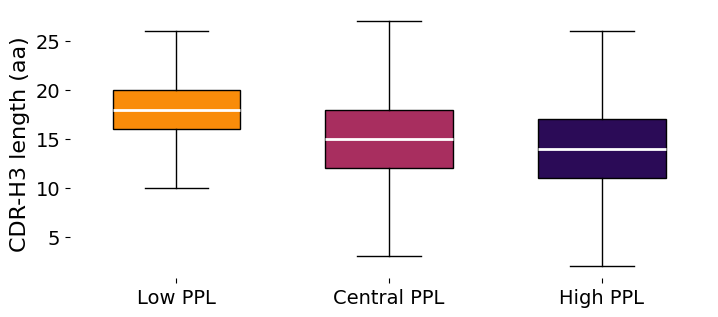

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os

# --------------------------------------------------------------
# 1)  Make sure df_con is in memory and has a seq_len column
# --------------------------------------------------------------
df_len = df_con.copy()
if "seq_len" not in df_len.columns:
    df_len["seq_len"] = df_len["sequence"].str.len()

# --------------------------------------------------------------
# 2)  Style (as before)
# --------------------------------------------------------------
plt.rcParams.update({
    "font.size":       16,
    "axes.titlesize":  18,
    "axes.labelsize":  16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

cmap   = get_cmap("inferno_r")
colors = {"upper":  cmap(0.85),   # Low  PPL  – dark
          "middle": cmap(0.55),   # Central  – mid
          "lower":  cmap(0.25)}   # High PPL – light
labels = {"lower": "Low PPL", "middle": "Central PPL", "upper": "High PPL"}

tails   = ["lower", "middle", "upper"]
data    = [df_len.loc[df_len["tail"] == t, "seq_len"] for t in tails]

# --------------------------------------------------------------
# 3)  Box-plot
# --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 3))      # even more compact

bp = ax.boxplot(data,
                positions=np.arange(len(tails)),
                widths=0.6,
                patch_artist=True,
                showfliers=False,                # hide outliers
                medianprops=dict(color="white", linewidth=2),
                whiskerprops=dict(linewidth=1),
                capprops=dict(linewidth=1))

# colour each box
for patch, t in zip(bp["boxes"], tails):
    patch.set_facecolor(colors[t])

# tick labels & axis
ax.set_xticks(np.arange(len(tails)))
ax.set_xticklabels([labels[t] for t in tails])
ax.set_ylabel("CDR-H3 length (aa)")
# ax.set_title("CDR-H3 length distribution by tail")  # optional

# remove the entire frame
for spine in ax.spines.values():
    spine.set_visible(False)

fig.tight_layout(pad=0.05)

# --------------------------------------------------------------
# 4)  High-quality export
# --------------------------------------------------------------
out_svg = "./PAPER_IMG/PAPER_aa_len_tails_box.svg"
out_png = "./PAPER_IMG/PAPER_aa_len_tails_box.png"

fig.savefig(out_svg, format="svg",  bbox_inches="tight", pad_inches=0.01)
fig.savefig(out_png, format="png",  dpi=600, bbox_inches="tight",
            pad_inches=0.01, pil_kwargs={"compress_level": 0})

print(f"✓ Plot saved as:\n  • {os.path.abspath(out_svg)}\n  • {os.path.abspath(out_png)}")


## WE HAVE SOME VERY VERY LONG CDRH3 ( THAT WE REMOVE FROM THE BOXPLOTS/KDE) check length

In [9]:
# 1. Aggiungo (se non l'hai già) una colonna con la lunghezza
df_con["seq_len"] = df_con["sequence"].str.len()

# 2. Filtro e ordino
df_long = (
    df_con.loc[df_con["seq_len"] > 50, ["id", "sequence", "seq_len", "tail","group"]]
          .sort_values("seq_len", ascending=False)
          .reset_index(drop=True)
)

# 3. Mostro il risultato
print(f"Found {len(df_long)} sequences longer than 50 aa, in the tails: {np.unique(df_long['tail'])}")
display(df_long)  

Found 322 sequences longer than 50 aa, in the tails: ['middle' 'upper']


,id,sequence,seq_len,tail,group
0,SRR7718568.10612,PRAGIARQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQ...,77,middle,diseased
1,SRR7717858.8877,TRTDWEYKRPGEWLEWVGRIKSKTDGGTTDYAAAVKGRFTISRDDT...,77,upper,healthy
2,SRR7718830.28519,ARELWLPPPPGIRPNADRTNGV*GKE*VLSRSLPSV*PALPLYMVR...,76,upper,diseased
3,SRR7717712.35689,AKGLRRLSEGPFHHLQRRRQDLTVSANDQPLMCETPELGAQ*LATL...,76,upper,diseased
4,SRR7718884.2274,ARRWSSRNLSHSGWDARRARAGRGGGSSCLVVALPPTPRPPKTGSP...,73,middle,diseased
...,...,...,...,...,...
317,SRR7718262.20609,PGPPWASGVQCPATPGPSPGSV*EGPRDLAGRQFLPGLLALLSQCD...,51,middle,diseased
318,SRR7718106.8073,ARTRQQLVPQ*HSPGQKSHPRAQGAPSDSEEPRVTVRIIGTSGPTT...,51,middle,diseased
319,SRR7717884.11068,LQRQCQQLPLSASEQPES*GHDRV*LCEPCVFAGKPVIRYSRFGQL...,51,upper,healthy
320,SRR7717884.29198,LQRQCQQLPLSASEQPES*GHDRV*LCEPCVFAGKPVIRYSRFGQL...,51,upper,healthy


     tail     group  count  min  median       mean  max
0  middle  diseased     94   51    58.0  58.638298   77
1  middle   healthy     49   52    59.0  58.265306   67
2   upper  diseased     89   51    60.0  60.191011   76
3   upper   healthy     90   51    58.5  58.711111   77


/tmp/ipykernel_3164680/579161108.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("inferno_r")


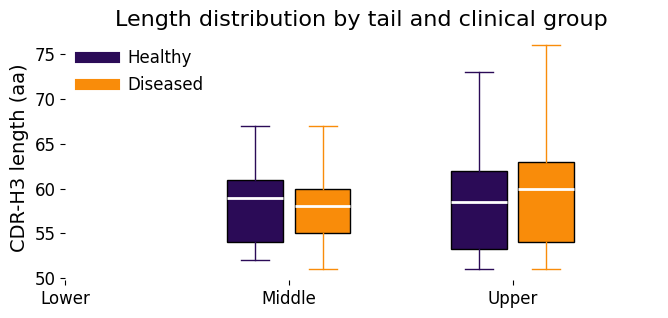

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap


# 1. Tabella di statistiche descrittive per tail × group
# ------------------------------------------------------------------
stats = (
    df_long.groupby(["tail", "group"])["seq_len"]
          .agg(["count", "min", "median", "mean", "max"])
          .reset_index()
)
print(stats)                 # oppure display(stats) in Jupyter

# ------------------------------------------------------------------
# 2. Box-plot compatto: Healthy vs Diseased per tail
# ------------------------------------------------------------------
plt.rcParams.update({
    "font.size":       14,
    "axes.titlesize":  16,
    "axes.labelsize":  14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# palette inferno_r coerente con gli altri grafici
cmap   = get_cmap("inferno_r")
col_H  = cmap(0.85)   # Healthy  (Low PPL tone, scuro)
col_D  = cmap(0.25)   # Diseased (High PPL tone, chiaro)

tails   = ["lower", "middle", "upper"]
groups  = ["healthy", "diseased"]
colors  = {"healthy": col_H, "diseased": col_D}

fig, ax = plt.subplots(figsize=(6.5, 3))

box_positions = {  # offset small shift for healthy/diseased within each tail
    "healthy": -0.15,
    "diseased": +0.15
}

for i, tail in enumerate(tails):
    for g in groups:
        data = df_long.loc[(df_long["tail"] == tail) & (df_long["group"] == g), "seq_len"]
        if data.empty:
            continue
        pos = i + box_positions[g]
        bp = ax.boxplot(data, positions=[pos],
                        widths=0.25, patch_artist=True,
                        boxprops=dict(facecolor=colors[g], linewidth=1),
                        medianprops=dict(color="white", linewidth=2),
                        whiskerprops=dict(color=colors[g]),
                        capprops=dict(color=colors[g]),
                        flierprops=dict(marker='.', markersize=3,
                                        markerfacecolor=colors[g],
                                        markeredgecolor=colors[g]),
                        showfliers=False)
# asse & legenda
ax.set_xticks(range(len(tails)))
ax.set_xticklabels([t.capitalize() for t in tails])
ax.set_ylabel("CDR-H3 length (aa)")
ax.set_title("Length distribution by tail and clinical group")

# legenda “manuale”
handles = [plt.Line2D([0],[0], lw=8, color=colors[g]) for g in groups]
ax.legend(handles, [g.capitalize() for g in groups], frameon=False)

# rimuovo frame
for spine in ax.spines.values():
    spine.set_visible(False)

fig.tight_layout(pad=0.05)
plt.show()


# SI

     tail     group    count  min  median       mean  max
0   lower  diseased   212479    8    17.0  17.674264   34
1   lower   healthy   219992    7    18.0  18.218199   46
2  middle  diseased  3824735    1    15.0  14.940026   77
3  middle   healthy  3960185    1    15.0  15.365229   67
4   upper  diseased   212485    1    13.0  13.688839   76
5   upper   healthy   220004    1    14.0  14.366421   77


/tmp/ipykernel_2704358/2518064611.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("inferno_r")


✓ Plot salvato come:
   • ./PAPER_IMG/SI_CDRH3_length_by_tail.svg
  • ./PAPER_IMG/SI_CDRH3_length_by_tail.png


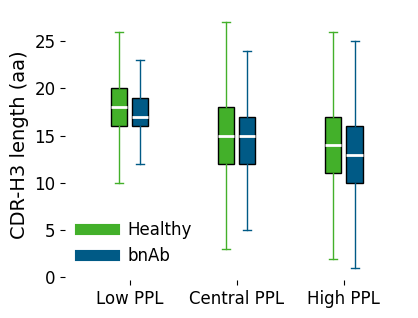

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

df_con["seq_len"] = df_con["sequence"].str.len()
# 1. Tabella di statistiche descrittive per tail × group
# ------------------------------------------------------------------
stats = (
    df_con.groupby(["tail", "group"])["seq_len"]
          .agg(["count", "min", "median", "mean", "max"])
          .reset_index()
)
print(stats)                 # oppure display(stats) in Jupyter

# ------------------------------------------------------------------
# 2. Box-plot compatto: Healthy vs Diseased per tail
# ------------------------------------------------------------------
plt.rcParams.update({
    "font.size":       14,
    "axes.titlesize":  16,
    "axes.labelsize":  14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# palette inferno_r coerente con gli altri grafici
cmap   = get_cmap("inferno_r")
col_H  = '#43B02A'   # Healthy  
col_D  = '#005A86'  # Diseased 

tails   = ["lower", "middle", "upper"]
groups  = ["healthy", "diseased"]
colors  = {"healthy": col_H, "diseased": col_D}

fig, ax = plt.subplots(figsize=(4, 3))

box_positions = {  # offset small shift for healthy/diseased within each tail
    "healthy": -0.1,
    "diseased": +0.10
}

for i, tail in enumerate(tails):
    for g in groups:
        data = df_con.loc[(df_con["tail"] == tail) & (df_con["group"] == g), "seq_len"]
        if data.empty:
            continue
        pos = i + box_positions[g]
        bp = ax.boxplot(data, positions=[pos],
                        widths=0.15, patch_artist=True,
                        boxprops=dict(facecolor=colors[g], linewidth=1),
                        medianprops=dict(color="white", linewidth=2),
                        whiskerprops=dict(color=colors[g]),
                        capprops=dict(color=colors[g]),
                        flierprops=dict(marker='.', markersize=3,
                                        markerfacecolor=colors[g],
                                        markeredgecolor=colors[g]),
                        showfliers=False)
# asse & legenda
ax.set_xticks(range(len(tails)))
ax.set_xticklabels([t.capitalize() for t in tails])
ax.set_ylabel("CDR-H3 length (aa)")
#ax.set_title("Length distribution by tail and clinical group")

# legenda “manuale”
handles = [plt.Line2D([0],[0], lw=8, color=colors[g]) for g in groups]
ax.legend(handles, [g.capitalize() for g in groups], frameon=False)

# rimuovo frame
for spine in ax.spines.values():
    spine.set_visible(False)

# ------------------------------------------------------------------
# 1.  Dove setti le etichette dell’asse x
# ------------------------------------------------------------------
new_xticklabels = ["Low PPL", "Central PPL", "High PPL"]
ax.set_xticks(range(len(tails)))
ax.set_xticklabels(new_xticklabels)

# ------------------------------------------------------------------
# 2.  Dove costruisci la legenda manuale
# ------------------------------------------------------------------
legend_labels = {"healthy": "Healthy", "diseased": "bnAb"}
handles = [plt.Line2D([0],[0], lw=8, color=colors[g]) for g in groups]
ax.legend(handles,
          [legend_labels[g] for g in groups],
          frameon=False)


fig.tight_layout(pad=0.05)
# … tutto il codice di costruzione del box-plot …

# ------------------------------------------------------------------
# Salvataggio high-quality
# ------------------------------------------------------------------
out_svg = "./PAPER_IMG/SI_CDRH3_length_by_tail.svg"
out_png = "./PAPER_IMG/SI_CDRH3_length_by_tail.png"

fig.savefig(out_svg, format="svg",
            bbox_inches="tight", pad_inches=0.01)

fig.savefig(out_png, format="png", dpi=1200,
            bbox_inches="tight", pad_inches=0.01,
            pil_kwargs={"compress_level": 0})   # nessuna compressione

print("✓ Plot salvato come:\n",
      f"  • {out_svg}\n  • {out_png}")

plt.show()

✓ Plot salvato come:
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/confronto/cdrh3_sequences_differences/PAPER_IMG/SI_aa_freq_tails_bygroup.svg
  • /ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/BEST_RESULTS/H3BERTA:HEALTHY:CDRH3:P3:JUNE2024/H3BERTA_analysis/PERPLEXITY_ANALYSIS/CINCINNATI_REPERTOIRES_PERPLEXITY/confronto/cdrh3_sequences_differences/PAPER_IMG/SI_aa_freq_tails_bygroup.png


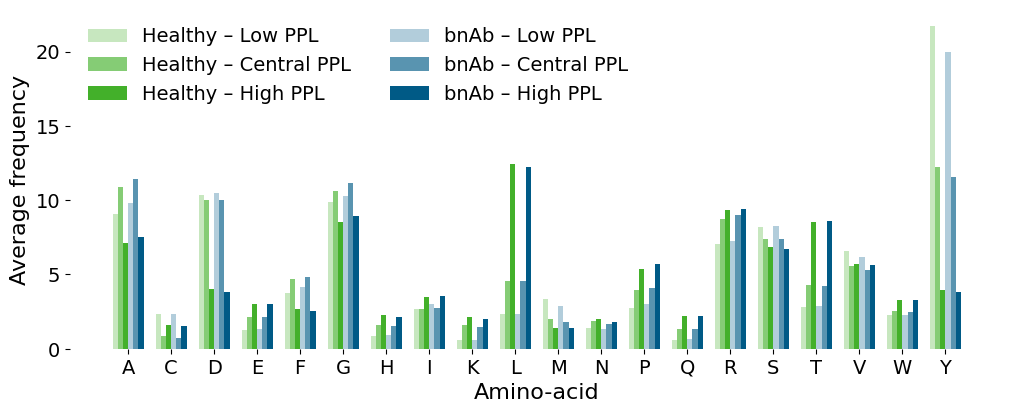

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex
from collections import Counter
import os

# ─────────────────────────────────────────────────────────────────────
# 1.  PARAMETRI & PALETTE
# ─────────────────────────────────────────────────────────────────────
# • Colori base per i due gruppi
BASE_HEALTHY  = "#43B02A"   # verde
BASE_DISEASED = "#005A86"   # blu

# • Funzione per creare n sfumature dal più scuro al più chiaro
def make_shades(hex_color, n=3, light=0.3):
    base = np.array(to_rgb(hex_color))
    return [
        to_hex(base * t + (1 - t))                # blending con bianco
        for t in np.linspace(1.0, light, n)       # 1.0 = colore pieno
    ]

# 3 tonalità per ogni condizione (Upper=più scuro, Lower=più chiaro)
h_shades = make_shades(BASE_HEALTHY,  3)          # [scuro, medio, chiaro]
d_shades = make_shades(BASE_DISEASED, 3)

pal_h   = [h_shades[2], h_shades[1], h_shades[0]] # [Low, Mid, High]
pal_dis = [d_shades[2], d_shades[1], d_shades[0]]

# • Mappatura etichette legenda
legend_labels = {"Healthy": "Healthy", "Diseased": "bnAb"}     # gruppi
tail_labels   = {"Lower": "Low PPL", "Middle": "Central PPL", "Upper": "High PPL"}

# • Stile matplotlib
plt.rcParams.update({
    "font.size":       16,
    "axes.titlesize":  18,
    "axes.labelsize":  16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

# ─────────────────────────────────────────────────────────────────────
# 2.  FUNZIONI DI SUPPORTO
# ─────────────────────────────────────────────────────────────────────
AA = list("ACDEFGHIKLMNPQRSTVWY")

def mean_freq(series):
    """Percentuale media di ciascun AA in un insieme di sequenze."""
    rows = []
    for seq in series:
        L = len(seq)
        c = Counter(seq)
        rows.append({aa: c.get(aa, 0) / L * 100 for aa in AA})
    return pd.DataFrame(rows).fillna(0).mean()

def profile_by_tail(df_subset, tag):
    """Restituisce 3 colonne (Lower/Middle/Upper) per un gruppo specifico."""
    return pd.concat([
        mean_freq(df_subset[df_subset["tail"] == "lower"]["sequence"]).rename(f"{tag}_Lower"),
        mean_freq(df_subset[df_subset["tail"] == "middle"]["sequence"]).rename(f"{tag}_Middle"),
        mean_freq(df_subset[df_subset["tail"] == "upper"]["sequence"]).rename(f"{tag}_Upper"),
    ], axis=1)

# ─────────────────────────────────────────────────────────────────────
# 3.  PREPARAZIONE DATI
# ─────────────────────────────────────────────────────────────────────
df = df_con.copy()   # il DataFrame di partenza deve avere:
                    # • sequence   (stringa a.a.)
                    # • tail       (lower / middle / upper)
                    # • group      (healthy / diseased)

plot_df = (
    pd.concat([
        profile_by_tail(df[df["group"] == "healthy"],  "Healthy"),
        profile_by_tail(df[df["group"] == "diseased"], "Diseased")
    ], axis=1)
    .reset_index().rename(columns={"index": "AA"})
)

col_order = [
    "Healthy_Lower", "Healthy_Middle", "Healthy_Upper",
    "Diseased_Lower", "Diseased_Middle", "Diseased_Upper"
]

# ─────────────────────────────────────────────────────────────────────
# 4.  PLOT
# ─────────────────────────────────────────────────────────────────────
x, w = np.arange(len(AA)), 0.12
off  = [-2.5*w, -1.5*w, -0.5*w, 0.5*w, 1.5*w, 2.5*w]

fig, ax = plt.subplots(figsize=(10, 4))
already_plotted = set()

for i, col in enumerate(col_order):
    group, tail = col.split("_")                       # es. Healthy, Lower
    idx         = ["Lower", "Middle", "Upper"].index(tail)
    color       = pal_h[idx] if group == "Healthy" else pal_dis[idx]
    hatch       = ""                                   # aggiungi "//" se vuoi

    # label personalizzata per la legenda
    full_label  = f"{legend_labels[group]} – {tail_labels[tail]}"
    label       = full_label if full_label not in already_plotted else None
    already_plotted.add(full_label)

    ax.bar(x + off[i], plot_df[col], width=w, color=color,
        label=label, hatch=hatch)

ax.set_xticks(x)
ax.set_xticklabels(AA)
ax.set_ylabel("Average frequency")
ax.set_xlabel("Amino-acid")
ax.legend(frameon=False, ncol=2, loc="upper left")

for spine in ax.spines.values():
    spine.set_visible(False)

fig.tight_layout(pad=0.15)

# ─────────────────────────────────────────────────────────────────────
# 5.  SALVATAGGIO
# ─────────────────────────────────────────────────────────────────────
out_svg = "./PAPER_IMG/SI_aa_freq_tails_bygroup.svg"
out_png = "./PAPER_IMG/SI_aa_freq_tails_bygroup.png"

fig.savefig(out_svg, format="svg",  bbox_inches="tight", pad_inches=0.01)
fig.savefig(out_png, format="png",  dpi=600, bbox_inches="tight",
            pad_inches=0.01, pil_kwargs={"compress_level": 0})

print(f"✓ Plot salvato come:\n  • {os.path.abspath(out_svg)}\n  • {os.path.abspath(out_png)}")